# Tutorial - Model Prediction 

In [1]:
#Import Section
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.linear_model import LinearRegression,BayesianRidge,ElasticNet,Lasso,SGDRegressor,Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import LabelEncoder,Imputer,OneHotEncoder,RobustScaler,StandardScaler,Imputer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA,KernelPCA
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor,VotingClassifier
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV,RandomizedSearchCV,StratifiedKFold,train_test_split
from sklearn.base import BaseEstimator,clone,TransformerMixin,RegressorMixin
from sklearn.svm import LinearSVR,SVR
#import xgboost 
from xgboost import XGBRegressor
#Import Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew
from scipy.stats.stats import pearsonr
%matplotlib inline

In [2]:
train = pd.read_csv('../input/train.csv',na_values = '#NAME?')

test = pd.read_csv('../input/test.csv',na_values = '#NAME?')

Let us examine using a scatter plot with GrLivArea vs Sale Price to observe any outliers at a glance

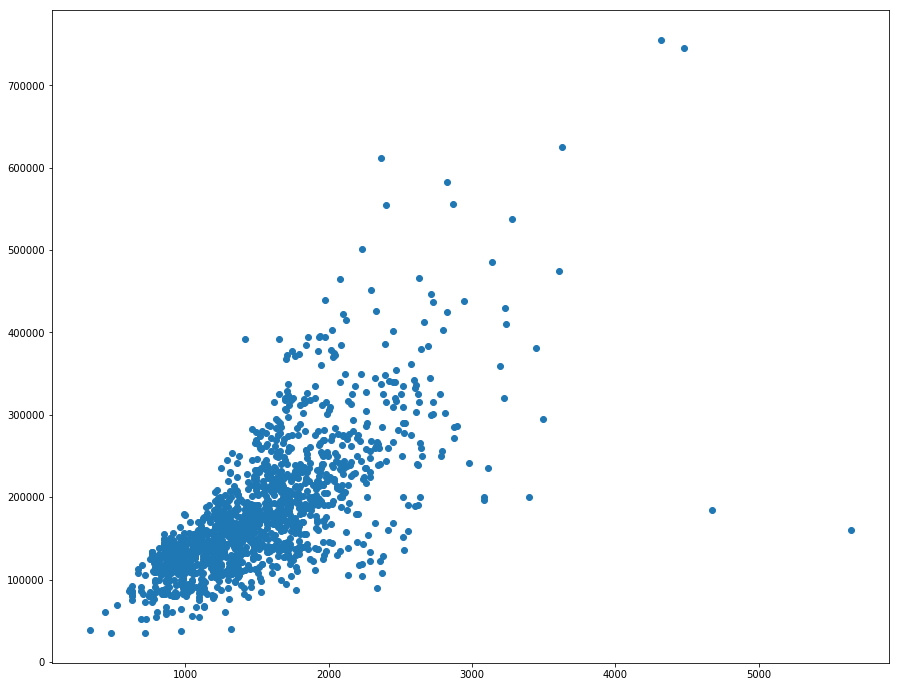

In [3]:
plt.figure(figsize=(15,12))

plt.scatter(x = train.GrLivArea,y = train.SalePrice)

So based on the above scatter plot let us drop some of those outlier observations .

In [4]:
train.drop(train[(train['GrLivArea'] >4000) & (train['SalePrice']<300000)].index,inplace = True)

In [5]:
train.shape,test.shape

((1458, 81), (1459, 80))

Let us concatenate both the training and test datasets into a single dataframe for ease of data cleaning and feature engineering.'Id' feature has no significance to our modelling since it is a continuous variable ,so dropping this feature on both train and test datasets.

In [6]:
full = pd.concat([train,test],ignore_index=True)
full.drop('Id',axis = 1,inplace = True)
full.shape

(2917, 80)

# Data Preprocessing

## Missing Values Treatment


For various reasons, many real world datasets contain missing values, often encoded as blanks, NaNs or other placeholders. Such datasets however are incompatible with scikit-learn estimators which assume that all values in an array are numerical, and that all have and hold meaning. A basic strategy to use incomplete datasets is to discard entire rows and/or columns containing missing values. However, this comes at the price of losing data which may be valuable (even though incomplete). A better strategy is to impute the missing values, i.e., to infer them from the known part of the data.

The Imputer class provides basic strategies for imputing missing values, either using the mean, the median or the most frequent value of the row or column in which the missing values are located. This class also allows for different missing values encodings.

Let us examine the entire set of missing values in the combined dataset for our initial understanding 

In [7]:
missing_values = full.isnull().sum()

missing_values[missing_values>0].sort_values(ascending = False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64

Based on the correlation heatmap in the EDA section its very clear that LotFrontage is correlated with LotArea and LotFrontage.So let us impute the missing values of LotFrontage based on the median of LotArea and Neighborhood. To achieve this let us first group Neighborhood and LotFrontage with respect to median,mean and count.

In [8]:
full.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        46.900000   43.0    20
Blueste        27.300000   24.0    10
BrDale         21.500000   21.0    30
BrkSide        55.789474   51.0    95
ClearCr        88.150000   80.5    20
CollgCr        71.336364   70.0   220
Crawfor        69.951807   70.0    83
Edwards        65.153409   64.5   176
Gilbert        74.207207   64.0   111
IDOTRR         62.241379   60.0    87
MeadowV        25.606061   21.0    33
Mitchel        75.144444   74.0    90
NAmes          75.210667   73.0   375
NPkVill        28.142857   24.0    21
NWAmes         81.517647   80.0    85
NoRidge        91.629630   89.0    54
NridgHt        84.184049   92.0   163
OldTown        61.777293   60.0   229
SWISU          59.068182   60.0    44
Sawyer         74.551020   72.0    98
SawyerW        70.669811   67.0   106
Somerst        64.549383   72.5   162
StoneBr        62.173913   60.0    46
Timber         81.157895   82.0    57
Veenker        72.000000   80.0    16

LotArea is a continuous feature so it is best to use panda's  qcut method to divide it into 10 parts.

In [9]:
full['LotAreaCut'] = pd.qcut(full.LotArea,10)

full.groupby([full['LotAreaCut']])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                           mean median count
LotAreaCut                                  
(1299.999, 4921.8]    35.741036   34.0   251
(4921.8, 7007.2]      55.460674   52.0   267
(7007.2, 7949.0]      62.959839   62.0   249
(7949.0, 8740.4]      67.113725   65.0   255
(8740.4, 9452.0]      69.959184   70.0   245
(9452.0, 10148.8]     73.988235   75.0   255
(10148.8, 11000.0]    73.636364   75.0   253
(11000.0, 12196.8]    83.371681   82.0   226
(12196.8, 14285.8]    84.973684   85.0   228
(14285.8, 215245.0]   92.846535   90.0   202

So let us impute the missing values of LotFrontage as stated above with the median of LotArea and Neighborhood. 

In [10]:
full['LotFrontage']= full.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x : x.fillna(x.median()))
full['LotFrontage']= full.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x : x.fillna(x.median()))

Now let us recheck the missing values to see our LotFrontage missing values are imputed successfully.

In [11]:
missing_values = full.isnull().sum()

missing_values[missing_values>0].sort_values(ascending = False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageArea         1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
dtype: int64

Now let us focus on numerical features with one missing value and replace them with 0 

In [12]:
columns = ["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in columns:
    full[col].fillna(0,inplace= True)

Now let us focus on some of the categorical features with  major count of missing values and replace them with 'None' 

In [13]:
columns1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish",
"GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col1 in columns1:
    full[col1].fillna('None',inplace = True)

Now let us focus on some of the categorical features with  fewer missing values and replace them with the most frequently occured value which is the mode of that feature. 

In [14]:
columns2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional",
            "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]

for col2 in columns2:
    full[col2].fillna(full[col2].mode()[0],inplace = True)

Now let us recheck if we have any other missing values that needs to be imputed except the SalePrice for the test dataset which is the target variable to be determined.

In [15]:
full.isnull().sum()[full.isnull().sum()>0]

SalePrice    1459
dtype: int64

In [16]:
numeric_features = full.select_dtypes(include=[np.number])
numeric_features.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage',
       'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold',
       'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'SalePrice',
       'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold'],
      dtype='object')

In [17]:
Numstr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold",
          "YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]

for i in Numstr:
    full[i]=full[i].astype(str)

In [18]:
full.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])

SalePrice                
                     mean    median count
MSSubClass                               
120         200779.080460  192000.0    87
150                   NaN       NaN     0
160         138647.380952  146000.0    63
180         102300.000000   88500.0    10
190         129613.333333  128250.0    30
20          185224.811567  159250.0   536
30           95829.724638   99900.0    69
40          156125.000000  142500.0     4
45          108591.666667  107500.0    12
50          143302.972222  132000.0   144
60          240403.542088  216000.0   297
70          166772.416667  156000.0    60
75          192437.500000  163500.0    16
80          169736.551724  166500.0    58
85          147810.000000  140750.0    20
90          133541.076923  135980.0    52

In [19]:
def map_values():
    full["oMSSubClass"] = full.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    full["oMSZoning"] = full.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    full["oNeighborhood"] = full.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    full["oCondition1"] = full.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    full["oBldgType"] = full.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    full["oHouseStyle"] = full.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    full["oExterior1st"] = full.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    full["oMasVnrType"] = full.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    full["oExterQual"] = full.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFoundation"] = full.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    full["oBsmtQual"] = full.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oBsmtExposure"] = full.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    full["oHeating"] = full.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    full["oHeatingQC"] = full.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oKitchenQual"] = full.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFunctional"] = full.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    full["oFireplaceQu"] = full.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oGarageType"] = full.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    full["oGarageFinish"] = full.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    full["oPavedDrive"] = full.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    full["oSaleType"] = full.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    full["oSaleCondition"] = full.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                
                        
                        
    
    return "Done!"


In [20]:
map_values()

'Done!'

In [21]:
# drop two unwanted columns
full.drop("LotAreaCut",axis=1,inplace=True)

full.drop(['SalePrice'],axis=1,inplace=True)

In [22]:
full.shape

(2917, 101)

In [23]:
full[['YearBuilt','YearRemodAdd','GarageYrBlt']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
0,2003,2003,2003.0
1,1976,1976,1976.0
2,2001,2002,2001.0
3,1915,1970,1998.0
4,2000,2000,2000.0


#### Label Encoding

LabelEncoder is a utility class to help normalize labels such that they contain only values between 0 and n_classes-1. This is sometimes useful for writing efficient Cython routines. LabelEncoder can be used as follows:

Let us create a class for the LabelEncoder to fit and transform some of the identified features


In [24]:
class labenc(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        label = LabelEncoder()
        X['YearBuilt']=label.fit_transform(X['YearBuilt'])
        X['YearRemodAdd']=label.fit_transform(X['YearRemodAdd'])
        X['GarageYrBlt']=label.fit_transform(X['GarageYrBlt'])
        return X
        

In [25]:
class skewness(BaseEstimator,TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        return X


In [26]:
class dummies(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X = pd.get_dummies(X)
        return X

## Pipelines

Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves two purposes here:

* Convenience: You only have to call fit and predict once on your data to fit a whole sequence of estimators.
* Joint parameter selection: You can grid search over parameters of all estimators in the pipeline at once.

All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.).

In [27]:
pipeline = Pipeline([('labenc',labenc()),('skewness',skewness(skew =1)),('dummies',dummies())])

In [28]:
full_copy = full.copy()
data_pipeline = pipeline.fit_transform(full_copy)

In [29]:
data_pipeline.shape

(2917, 405)

In [30]:
data_pipeline.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,...,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,6.753438,854,0.0,706.0,0.0,150.0,0.000000,0,2,548.0,...,1,0,1,1,0,0,0,1,0,0
1,7.141245,0,0.0,978.0,0.0,284.0,0.000000,1,2,460.0,...,1,0,1,1,0,0,1,0,0,0
2,6.825460,866,0.0,486.0,0.0,434.0,0.000000,1,2,608.0,...,1,0,1,1,0,0,0,1,0,0
3,6.869014,756,0.0,216.0,0.0,540.0,5.609472,1,1,642.0,...,1,0,1,1,0,1,0,0,0,0
4,7.044033,1053,0.0,655.0,0.0,490.0,0.000000,1,2,836.0,...,1,0,1,1,0,0,0,1,0,0


In [31]:
robust_scaler = RobustScaler()
    

In [32]:
n_train = train.shape[0]
n_train

1458

In [33]:
X= data_pipeline[:n_train]
y = train.SalePrice
test_X = data_pipeline[n_train:]
X.shape,y.shape,test_X.shape

((1458, 405), (1458,), (1459, 405))

In [34]:
X_scaled = robust_scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = robust_scaler.transform(test_X)

In [35]:
X_scaled.shape,y_log.shape,test_X.shape

((1458, 405), (1458,), (1459, 405))

## Feature Selection

#### Lasso Regresson:
Power of regualization is that it can automatically do feature selection for you. ''Regularized regression' automatically penalizes extra features and for features that don't help regression results enough, can set its coefficient to zero.

Normal Linear Regression:
Just wants to minimize SSE and uses all the features made available to it and it'll assign each one a coefficient of regression

Lasso Regression (Regularized Regression):
In addition to minimizing SSE, also whats to minimize the number of features so a penalty parameter is used for additional features. Lasso regression automatically takes in account this penalty parameter and in so doing, it helps identify which features have the most important effect on the regression and eliminate (or set to zero) the coefficients to the features that basically don't help.

It will try adding features in one at a time and if the new feature does't improve the fit enough to outweigh the penalty term of including that feature then it won't be added (coefficient is set to zero). The gain in terms of precision/goodness of fit has to be bigger than the loss that I take as a result of having that additional feature in my regression

In [36]:
lasso = Lasso(alpha = 0.001)
lasso.fit(X_scaled,y_log)
y_pred_lasso = lasso.predict(test_X_scaled)

In [37]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=data_pipeline.columns)
FI_lasso.sort_values("Feature Importance",ascending=False)

,Feature Importance
GrLivArea,0.108870
OverallQual,0.102583
2ndFlrSF,0.074221
YearBuilt,0.068926
1stFlrSF,0.059760
Functional_Typ,0.051862
TotalBsmtSF,0.050261
Neighborhood_Crawfor,0.049942
OverallCond,0.045527
oNeighborhood,0.044311


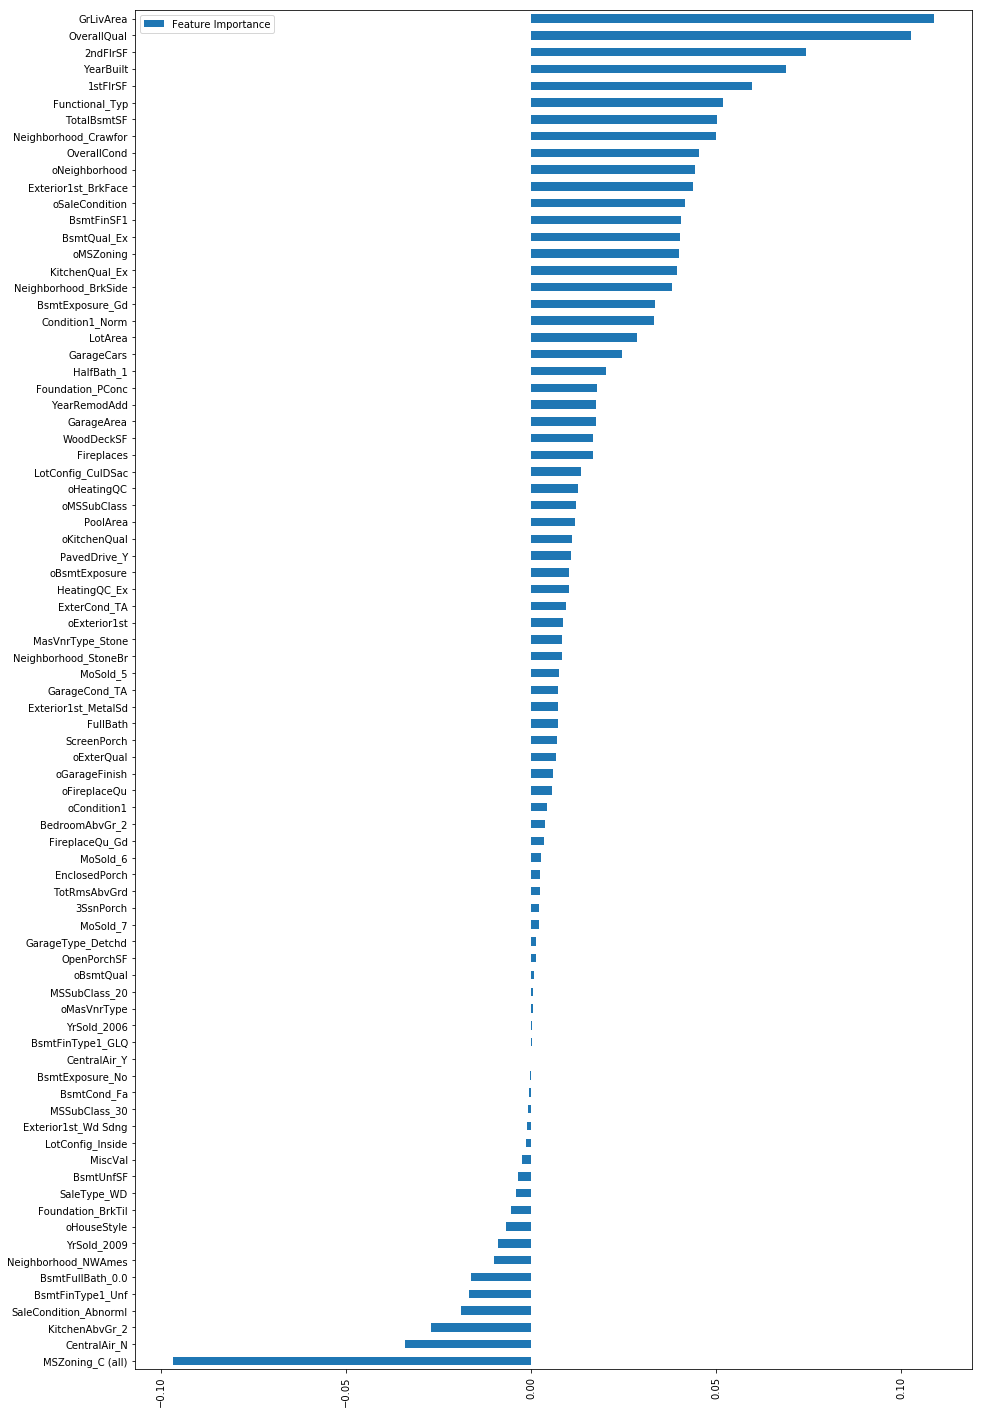

In [38]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [39]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
            X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
            
            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]
            
           
            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    
            return X

In [40]:
pipeline = Pipeline([('labenc',labenc()),('add_feature', add_feature(additional=2)),
                     ('skewness',skewness(skew =1)),('dummies',dummies())])

full_pipe = pipeline.fit_transform(full)
full_pipe.shape

(2917, 426)

In [41]:
n_train=train.shape[0]
X = full_pipe[:n_train]
test_X = full_pipe[n_train:]
y= train.SalePrice

X_scaled = robust_scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = robust_scaler.transform(test_X)

In [42]:
print(X_scaled.shape)

(1458, 426)


### Principal Component Analysis (PCA)

PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance. In scikit-learn, PCA is implemented as a transformer object that learns n components in its fit method, and can be used on new data to project it on these components.

The optional parameter whiten=True makes it possible to project the data onto the singular space while scaling each component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy of the signal: this is for example the case for Support Vector Machines with the RBF kernel and the K-Means clustering algorithm.

Notice the code below shows .95 for the number of component parameters.It means that as per scikit learn choose the number of principle components such that 95% of the variance is retained.  

In [43]:
pca = PCA(0.95)

#pca = PCA(n_components = 426)
X_scaled = pca.fit_transform(X_scaled)
#X_scaled = pca.inverse_transform(lower_dimension_pca)
var1 = np.round(pca.explained_variance_ratio_*100, decimals = 1)
var1

array([25.1,  8.3,  6.2,  4.7,  3.9,  3.5,  2.9,  2.5,  2.3,  2.2,  1.7,
        1.5,  1.3,  1.2,  1.2,  1.1,  1. ,  0.9,  0.9,  0.8,  0.8,  0.7,
        0.7,  0.7,  0.7,  0.6,  0.6,  0.6,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,
        0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,
        0.2,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1])

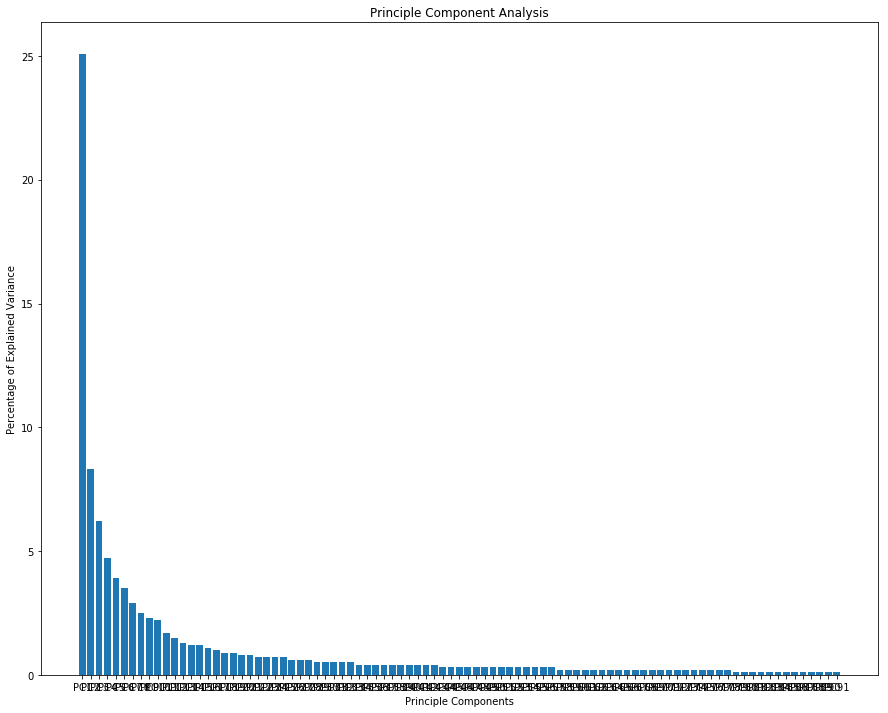

In [44]:
label =['PC' + str(x) for x in range(1,len(var1)+1)]
plt.figure(figsize=(15,12))
plt.bar(x=range(1,len(var1)+1), height = var1 ,tick_label = label)

plt.ylabel("Percentage of Explained Variance")
plt.xlabel("Principle Components")
plt.title("Principle Component Analysis")
plt.show()


In [45]:
test_X_scaled = pca.fit_transform(test_X_scaled)
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
var

array([26. ,  8. ,  6.7,  4.7,  3.9,  3.7,  3.1,  2.7,  2.4,  2.1,  1.6,
        1.4,  1.3,  1.2,  1.1,  1.1,  1. ,  0.9,  0.8,  0.8,  0.7,  0.7,
        0.6,  0.6,  0.6,  0.6,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.4,
        0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,
        0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,
        0.2,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1])

In [46]:
#test_X_scaled = pca.inverse_transform(test_X_scaled)

In [47]:
X_scaled.shape, test_X_scaled.shape

((1458, 91), (1459, 90))

# Modeling & Evaluation

In [48]:
# Define Root Mean Square Error 
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model,X,y,scoring="neg_mean_squared_error",cv=5))
    return rmse



We choose 13 models and use 5-folds cross-calidation to evaluate these models.

### Models include:

   - LinearRegression
   - Ridge
   - Lasso
   - Random Forest
   - Gradient Boosting Tree
   - Support Vector Regression
   - Linear Support Vector Regression
   - ElasticNet
   - Stochastic Gradient Descent
   - BayesianRidge
   - KernelRidge
   - ExtraTreesRegressor
   - XgBoost



In [49]:
models = [LinearRegression(),
             Ridge(),
             Lasso(alpha=0.01,max_iter=10000),
             RandomForestRegressor(),
             GradientBoostingRegressor(),
             SVR(),
             LinearSVR(),
             ElasticNet(alpha = 0.001,max_iter=10000),
             SGDRegressor(max_iter=1000, tol = 1e-3),
             BayesianRidge(),
             KernelRidge(alpha=0.6,kernel='polynomial',degree = 2,coef0=2.5),
             ExtraTreesRegressor(),
             XGBRegressor()]

names = ['LR','Ridge','Lasso','RF','GBR','SVR','LSVR','ENet','SGDR','BayRidge','Kernel','XTreeR','XGBR']

In [50]:
for model,name in zip(models,names):
    score = rmse_cv(model,X_scaled,y_log)
    print("{}: {:.6f}, {:4f}".format(name,score.mean(),score.std()))

LR: 0.113060, 0.004656
Ridge: 0.112999, 0.004656
Lasso: 0.121474, 0.006045
RF: 0.136611, 0.005069
GBR: 0.123818, 0.007205
SVR: 0.124044, 0.007980
LSVR: 0.114704, 0.007094
ENet: 0.112351, 0.004803
SGDR: 0.126782, 0.009215
BayRidge: 0.111744, 0.004701
Kernel: 0.110677, 0.004605
XTreeR: 0.134527, 0.004392
[16:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBR: 0.124617, 0.006644


-Next we do some hyperparameters tuning.So what is hyperparameter tuning ? Lets understand the concepts first.

### Hyper-parameter Tuning

Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. Typical examples include C, kernel and gamma for Support Vector Classifier, alpha for Lasso, etc.

It is possible and recommended to search the hyper-parameter space for the best Cross-validation i.e evaluating estimator performance score.

Any parameter provided when constructing an estimator may be optimized in this manner. Specifically, to find the names and current values for all parameters for a given estimator, we can use the following method

estimator.get_params()

A search consists of:

   - an estimator (regressor or classifier such as sklearn.svm.SVC());
   - a parameter space;
   - a method for searching or sampling candidates;
   - a cross-validation scheme; 
   - a score function.

Some models allow for specialized, efficient parameter search strategies, outlined below.

Two generic approaches to sampling search candidates are provided in scikit-learn: 

- GridSearchCV :For given values, GridSearchCV exhaustively considers all parameter combinations. The grid search provided by GridSearchCV exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter. 

For instance, the following param_grid specifies that it has one grid to be explored that is a linear kernel with alpha values in [0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0009], and 'max_iter' i.e maximum 10000 iterations.

param_grid = {'alpha':[0.01,0.001,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0009],'max_iter':[10000]}


- RandomizedSearchCV: It can sample a given number of candidates from a parameter space with a specified distribution. 

After describing these tools we detail best practice applicable to both approaches.

Note that it is common that a small subset of those parameters can have a large impact on the predictive or computation performance of the model while others can be left to their default values. It is recommend to read the docstring of the estimator class to get a finer understanding of their expected behavior.

I think it is enough of the theory .Now lets jump into practice.

Let us create two classes grid() and random() which basically instantiate the GridSearchCV and RandomizedCV objects and we pass the model and param_grid and return the results and best parameters for cross validation scores.

In [51]:
class grid():
    def __init__(self,model):
        self.model = model
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5,scoring='neg_mean_squared_error')
        grid_search.fit(X,y)
        print(grid_search.best_params_,np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

class random():
    def __init__(self,model):
        self.model = model
    def random_get(self,X,y,param_grid):
        random_search = RandomizedSearchCV(self.model,param_grid,random_state= 0,
                                           n_iter = 10,scoring='neg_mean_squared_error')
        random_search.fit(X,y)
        print(random_search.best_params_,np.sqrt(-random_search.best_score_))
        random_search.cv_results_['mean_test_score'] = np.sqrt(-random_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(random_search.cv_results_)[['params','mean_test_score','std_test_score']])

#### GridSearchCV - Lasso

In [52]:
grid(Lasso()).grid_get(X_scaled,y_log,{'alpha':[0.01,0.001,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0009],
                                       'max_iter':[10000]})

{'alpha': 0.0005, 'max_iter': 10000} 0.11247457828979626
                                 params  mean_test_score  std_test_score
0    {'alpha': 0.01, 'max_iter': 10000}         0.121629        0.001502
1   {'alpha': 0.001, 'max_iter': 10000}         0.112655        0.001131
2  {'alpha': 0.0001, 'max_iter': 10000}         0.112901        0.001076
3  {'alpha': 0.0002, 'max_iter': 10000}         0.112714        0.001085
4  {'alpha': 0.0003, 'max_iter': 10000}         0.112584        0.001090
5  {'alpha': 0.0004, 'max_iter': 10000}         0.112503        0.001096
6  {'alpha': 0.0005, 'max_iter': 10000}         0.112475        0.001101
7  {'alpha': 0.0006, 'max_iter': 10000}         0.112487        0.001103
8  {'alpha': 0.0007, 'max_iter': 10000}         0.112502        0.001109
9  {'alpha': 0.0009, 'max_iter': 10000}         0.112580        0.001122


The GridSearchCV instance implements the usual estimator API: when “fitting” it on a dataset all the possible combinations of parameter values are evaluated and the best combination is retained.
In this case we have the best combination of parameters identified as 

{'alpha': 0.0005, 'max_iter': 10000} 0.11247457829

using GridSearchCV. In coincidence the same best combination of parameters are identified using RandomizedSearchCV as below.

#### RandomizedSearchCV - Lasso

In [53]:
random(Lasso()).random_get(X_scaled,y_log,{'alpha':[0.01,0.001,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0009]})

{'alpha': 0.0007} 0.11285036253488911
              params  mean_test_score  std_test_score
0    {'alpha': 0.01}         0.121429        0.002229
1   {'alpha': 0.001}         0.112940        0.001449
2  {'alpha': 0.0001}         0.113711        0.001217
3  {'alpha': 0.0002}         0.113450        0.001246
4  {'alpha': 0.0003}         0.113236        0.001277
5  {'alpha': 0.0004}         0.113062        0.001301
6  {'alpha': 0.0005}         0.112944        0.001326
7  {'alpha': 0.0006}         0.112885        0.001352
8  {'alpha': 0.0007}         0.112850        0.001376
9  {'alpha': 0.0009}         0.112890        0.001422


While using a grid of parameter settings is currently the most widely used method for parameter optimization, other search methods have more favourable properties. RandomizedSearchCV implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:

   - A budget can be chosen independent of the number of parameters and possible values.
   - Adding parameters that do not influence the performance does not decrease efficiency.

Specifying how parameters should be sampled is done using a dictionary, very similar to specifying parameters for GridSearchCV. Additionally, a computation budget, being the number of sampled candidates or sampling iterations, is specified using the n_iter parameter. For each parameter, either a distribution over possible values or a list of discrete choices (which will be sampled uniformly) can be specified.

#### GridSearchCV-Ridge 

In [54]:
grid(Ridge()).grid_get(X_scaled,y_log,
                       {'alpha':[10,20,25,30,35,40,45,50,55,57,60,65,70,75,80,100],'max_iter':[10000]})

{'alpha': 100, 'max_iter': 10000} 0.11137865056618505
                               params  mean_test_score  std_test_score
0    {'alpha': 10, 'max_iter': 10000}         0.112626        0.001069
1    {'alpha': 20, 'max_iter': 10000}         0.112236        0.001067
2    {'alpha': 25, 'max_iter': 10000}         0.112082        0.001067
3    {'alpha': 30, 'max_iter': 10000}         0.111950        0.001067
4    {'alpha': 35, 'max_iter': 10000}         0.111838        0.001068
5    {'alpha': 40, 'max_iter': 10000}         0.111742        0.001069
6    {'alpha': 45, 'max_iter': 10000}         0.111661        0.001070
7    {'alpha': 50, 'max_iter': 10000}         0.111593        0.001071
8    {'alpha': 55, 'max_iter': 10000}         0.111536        0.001072
9    {'alpha': 57, 'max_iter': 10000}         0.111517        0.001072
10   {'alpha': 60, 'max_iter': 10000}         0.111490        0.001073
11   {'alpha': 65, 'max_iter': 10000}         0.111453        0.001075
12   {'alpha': 70, 'max

#### RandomizedSearchCV - Ridge 

In [55]:
random(Ridge()).random_get(X_scaled,y_log,
                       {'alpha':[10,20,25,30,35,40,45,50,55,57,60,65,70,75,80,100],'max_iter':[10000]})

{'max_iter': 10000, 'alpha': 80} 0.11186519018320686
                             params  mean_test_score  std_test_score
0  {'max_iter': 10000, 'alpha': 20}         0.112838        0.001308
1  {'max_iter': 10000, 'alpha': 45}         0.112150        0.001404
2  {'max_iter': 10000, 'alpha': 55}         0.112012        0.001434
3  {'max_iter': 10000, 'alpha': 57}         0.111991        0.001439
4  {'max_iter': 10000, 'alpha': 75}         0.111877        0.001483
5  {'max_iter': 10000, 'alpha': 35}         0.112354        0.001370
6  {'max_iter': 10000, 'alpha': 25}         0.112648        0.001330
7  {'max_iter': 10000, 'alpha': 80}         0.111865        0.001494
8  {'max_iter': 10000, 'alpha': 60}         0.111963        0.001447
9  {'max_iter': 10000, 'alpha': 50}         0.112073        0.001420


####  GridSearchCV - Linear SVR

In [56]:
param_grid = {'C':[0.05,0.1,0.15,0.2],"epsilon":[0.0015,0.002,0.0025,0.025,0.0004]}
   
grid(LinearSVR()).grid_get(X_scaled,y_log,param_grid)

{'C': 0.2, 'epsilon': 0.0015} 0.1116875889761236
                            params  mean_test_score  std_test_score
0   {'C': 0.05, 'epsilon': 0.0015}         0.114994        0.001192
1    {'C': 0.05, 'epsilon': 0.002}         0.114905        0.001217
2   {'C': 0.05, 'epsilon': 0.0025}         0.114976        0.001211
3    {'C': 0.05, 'epsilon': 0.025}         0.114063        0.001192
4   {'C': 0.05, 'epsilon': 0.0004}         0.115220        0.001225
5    {'C': 0.1, 'epsilon': 0.0015}         0.112940        0.001157
6     {'C': 0.1, 'epsilon': 0.002}         0.112959        0.001126
7    {'C': 0.1, 'epsilon': 0.0025}         0.112773        0.001117
8     {'C': 0.1, 'epsilon': 0.025}         0.112446        0.001135
9    {'C': 0.1, 'epsilon': 0.0004}         0.113030        0.001125
10  {'C': 0.15, 'epsilon': 0.0015}         0.111911        0.001152
11   {'C': 0.15, 'epsilon': 0.002}         0.111926        0.001161
12  {'C': 0.15, 'epsilon': 0.0025}         0.111953        0.001164

####  RandomizedSearchCV - Linear SVR

In [57]:
param_grid = {'C':[0.05,0.1,0.15,0.2],"epsilon":[0.0015,0.002,0.0025,0.025,0.0004]}
   
random(LinearSVR()).random_get(X_scaled,y_log,param_grid)

{'epsilon': 0.0025, 'C': 0.2} 0.11313425556864341
                           params  mean_test_score  std_test_score
0    {'epsilon': 0.025, 'C': 0.2}         0.113255        0.001652
1   {'epsilon': 0.002, 'C': 0.05}         0.117629        0.001708
2   {'epsilon': 0.0004, 'C': 0.2}         0.113699        0.001461
3    {'epsilon': 0.025, 'C': 0.1}         0.114357        0.001484
4  {'epsilon': 0.0015, 'C': 0.15}         0.113772        0.001525
5   {'epsilon': 0.0025, 'C': 0.2}         0.113134        0.001526
6    {'epsilon': 0.002, 'C': 0.1}         0.114383        0.001455
7   {'epsilon': 0.025, 'C': 0.15}         0.113569        0.001698
8  {'epsilon': 0.0004, 'C': 0.05}         0.117861        0.001733
9  {'epsilon': 0.0025, 'C': 0.05}         0.117677        0.001751


#### GridSearchCV SVR

In [58]:
param_grid = {'C':[11,13,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]}
grid(SVR()).grid_get(X_scaled,y_log,param_grid)

{'C': 15, 'epsilon': 0.009, 'gamma': 0.0004, 'kernel': 'rbf'} 0.11074650225277971
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.111167   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.110940   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.111197   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.110976   
4   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.111062   
5   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.110834   
6   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.111118   
7   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.110820   
8   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.110997   
9   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.110751   
10  {'C': 15, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.111091   
11  {'C': 15, 'epsilon': 0.009

#### RandomizedSearchCV SVR 

In [59]:
param_grid = {'C':[11,13,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]}
random(SVR()).random_get(X_scaled,y_log,param_grid)

{'kernel': 'rbf', 'gamma': 0.0004, 'epsilon': 0.009, 'C': 15} 0.11141091830847896
                                              params  mean_test_score  \
0  {'kernel': 'rbf', 'gamma': 0.0003, 'epsilon': ...         0.111924   
1  {'kernel': 'rbf', 'gamma': 0.0004, 'epsilon': ...         0.111411   
2  {'kernel': 'rbf', 'gamma': 0.0003, 'epsilon': ...         0.111993   
3  {'kernel': 'rbf', 'gamma': 0.0003, 'epsilon': ...         0.111787   
4  {'kernel': 'rbf', 'gamma': 0.0003, 'epsilon': ...         0.112054   
5  {'kernel': 'rbf', 'gamma': 0.0003, 'epsilon': ...         0.111842   
6  {'kernel': 'rbf', 'gamma': 0.0004, 'epsilon': ...         0.111670   
7  {'kernel': 'rbf', 'gamma': 0.0004, 'epsilon': ...         0.111497   
8  {'kernel': 'rbf', 'gamma': 0.0004, 'epsilon': ...         0.111467   
9  {'kernel': 'rbf', 'gamma': 0.0004, 'epsilon': ...         0.111654   

   std_test_score  
0        0.001725  
1        0.001707  
2        0.001727  
3        0.001730  
4        0.001

#### GridSearchCV Kernel Ridge 

In [60]:
param_grid={'alpha':[0.1,0.15,0.2,0.25], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.6,0.7,0.75,0.8,0.9]}
grid(KernelRidge()).grid_get(X_scaled,y_log,param_grid)

{'alpha': 0.25, 'coef0': 0.9, 'degree': 3, 'kernel': 'polynomial'} 0.12203965217700952
                                               params  mean_test_score  \
0   {'alpha': 0.1, 'coef0': 0.6, 'degree': 3, 'ker...         0.142483   
1   {'alpha': 0.1, 'coef0': 0.7, 'degree': 3, 'ker...         0.132241   
2   {'alpha': 0.1, 'coef0': 0.75, 'degree': 3, 'ke...         0.129418   
3   {'alpha': 0.1, 'coef0': 0.8, 'degree': 3, 'ker...         0.127492   
4   {'alpha': 0.1, 'coef0': 0.9, 'degree': 3, 'ker...         0.125300   
5   {'alpha': 0.15, 'coef0': 0.6, 'degree': 3, 'ke...         0.143703   
6   {'alpha': 0.15, 'coef0': 0.7, 'degree': 3, 'ke...         0.131884   
7   {'alpha': 0.15, 'coef0': 0.75, 'degree': 3, 'k...         0.128578   
8   {'alpha': 0.15, 'coef0': 0.8, 'degree': 3, 'ke...         0.126293   
9   {'alpha': 0.15, 'coef0': 0.9, 'degree': 3, 'ke...         0.123630   
10  {'alpha': 0.2, 'coef0': 0.6, 'degree': 3, 'ker...         0.145376   
11  {'alpha': 0.2, 'coef0

#### RandomizedSearchCV Kernel Ridge 

In [61]:
param_grid={'alpha':[0.1,0.15,0.2,0.25], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.6,0.7,0.75,0.8,0.9]}
random(KernelRidge()).random_get(X_scaled,y_log,param_grid)

{'kernel': 'polynomial', 'degree': 3, 'coef0': 0.9, 'alpha': 0.25} 0.1247518700666709
                                              params  mean_test_score  \
0  {'kernel': 'polynomial', 'degree': 3, 'coef0':...         0.129213   
1  {'kernel': 'polynomial', 'degree': 3, 'coef0':...         0.136825   
2  {'kernel': 'polynomial', 'degree': 3, 'coef0':...         0.124752   
3  {'kernel': 'polynomial', 'degree': 3, 'coef0':...         0.129704   
4  {'kernel': 'polynomial', 'degree': 3, 'coef0':...         0.153083   
5  {'kernel': 'polynomial', 'degree': 3, 'coef0':...         0.132847   
6  {'kernel': 'polynomial', 'degree': 3, 'coef0':...         0.136701   
7  {'kernel': 'polynomial', 'degree': 3, 'coef0':...         0.129272   
8  {'kernel': 'polynomial', 'degree': 3, 'coef0':...         0.127858   
9  {'kernel': 'polynomial', 'degree': 3, 'coef0':...         0.133267   

   std_test_score  
0        0.002386  
1        0.002670  
2        0.002064  
3        0.002265  
4        0

#### GridSearchCV - ElasticNet 

In [62]:
grid(ElasticNet()).grid_get(X_scaled,y_log,{'alpha':[0.004,0.005,0.006,0.0065],
                                            'l1_ratio':[0.065,0.06,0.070,0.075],'max_iter':[10000]})

{'alpha': 0.0065, 'l1_ratio': 0.07, 'max_iter': 10000} 0.11228834245625842
                                               params  mean_test_score  \
0   {'alpha': 0.004, 'l1_ratio': 0.065, 'max_iter'...         0.112460   
1   {'alpha': 0.004, 'l1_ratio': 0.06, 'max_iter':...         0.112481   
2   {'alpha': 0.004, 'l1_ratio': 0.07, 'max_iter':...         0.112442   
3   {'alpha': 0.004, 'l1_ratio': 0.075, 'max_iter'...         0.112427   
4   {'alpha': 0.005, 'l1_ratio': 0.065, 'max_iter'...         0.112373   
5   {'alpha': 0.005, 'l1_ratio': 0.06, 'max_iter':...         0.112388   
6   {'alpha': 0.005, 'l1_ratio': 0.07, 'max_iter':...         0.112360   
7   {'alpha': 0.005, 'l1_ratio': 0.075, 'max_iter'...         0.112348   
8   {'alpha': 0.006, 'l1_ratio': 0.065, 'max_iter'...         0.112310   
9   {'alpha': 0.006, 'l1_ratio': 0.06, 'max_iter':...         0.112321   
10  {'alpha': 0.006, 'l1_ratio': 0.07, 'max_iter':...         0.112304   
11  {'alpha': 0.006, 'l1_ratio': 0.07

#### RandomizedSearchCV - ElasticNet 

In [63]:
random(ElasticNet()).random_get(X_scaled,y_log,{'alpha':[0.004,0.005,0.006,0.0065],
                                            'l1_ratio':[0.065,0.06,0.070,0.075],'max_iter':[10000]})

{'max_iter': 10000, 'l1_ratio': 0.07, 'alpha': 0.0065} 0.1127578611851628
                                              params  mean_test_score  \
0  {'max_iter': 10000, 'l1_ratio': 0.06, 'alpha':...         0.113154   
1  {'max_iter': 10000, 'l1_ratio': 0.07, 'alpha':...         0.112928   
2  {'max_iter': 10000, 'l1_ratio': 0.065, 'alpha'...         0.112838   
3  {'max_iter': 10000, 'l1_ratio': 0.06, 'alpha':...         0.112873   
4  {'max_iter': 10000, 'l1_ratio': 0.06, 'alpha':...         0.112820   
5  {'max_iter': 10000, 'l1_ratio': 0.065, 'alpha'...         0.112965   
6  {'max_iter': 10000, 'l1_ratio': 0.07, 'alpha':...         0.113084   
7  {'max_iter': 10000, 'l1_ratio': 0.07, 'alpha':...         0.112758   
8  {'max_iter': 10000, 'l1_ratio': 0.07, 'alpha':...         0.112807   
9  {'max_iter': 10000, 'l1_ratio': 0.075, 'alpha'...         0.112895   

   std_test_score  
0        0.001281  
1        0.001316  
2        0.001330  
3        0.001324  
4        0.001332  
5 

## Ensemble Methods

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

Ensemble Approach

- Different training sets
- Different feature sampling
- Different algorithms
- Different (hyper) parameters
- Clever aggregation

Ensemble Methods

- Averaging/Bagging - To ensemble several good models to produce a less variance model.
- Boosting
- Voting
- Stacking



* Averaging - In averaging methods, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.

Examples: Bagging methods, Forests of randomized trees, ...

In ensemble algorithms, bagging methods form a class of algorithms which build several instances of a black-box estimator on random subsets of the original training set and then aggregate their individual predictions to form a final prediction. These methods are used as a way to reduce the variance of a base estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it. In many cases, bagging methods constitute a very simple way to improve with respect to a single model, without making it necessary to adapt the underlying base algorithm. As they provide a way to reduce overfitting, bagging methods work best with strong and complex models (e.g., fully developed decision trees), in contrast with boosting methods which usually work best with weak models (e.g., shallow decision trees).

Bagging methods come in many flavours but mostly differ from each other by the way they draw random subsets of the training set:

* When random subsets of the dataset are drawn as random subsets of the samples, then this algorithm is known as Patching
* When samples are drawn with replacement, then the method is known as Bagging
* When random subsets of the dataset are drawn as random subsets of the features, then the method is known as Random Subspaces
* Finally, when base estimators are built on subsets of both samples and features, then the method is known as Random Patches


In scikit-learn, bagging methods are offered as a unified BaggingClassifier meta-estimator (resp. BaggingRegressor), taking as input a user-specified base estimator along with parameters specifying the strategy to draw random subsets. In particular, max_samples and max_features control the size of the subsets (in terms of samples and features), while bootstrap and bootstrap_features control whether samples and features are drawn with or without replacement. When using a subset of the available samples the generalization accuracy can be estimated with the out-of-bag samples by setting oob_score=True. 

Random forests are somewhat special. They happen to be so frequently used a bagging method that they have become their own method. They are in that way the same as a classic Supervised Estimator with all the base functionality, plus a little extra bagging goodness.



#### Weight Average

In [64]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,model,weight):
        self.model = model
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.model]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w


In [65]:
lasso = Lasso(alpha= 0.0005, max_iter= 10000)
ridge = Ridge(alpha=64, max_iter= 10000)
svr = SVR(C = 13, epsilon= 0.009, gamma = 0.0004, kernel = 'rbf')
ker = KernelRidge(alpha=0.25 ,kernel='polynomial',degree=3 , coef0=0.9)
ela = ElasticNet(alpha=0.0065,l1_ratio=0.065,max_iter=10000)
bay = BayesianRidge()

In [66]:

lasso = Lasso(alpha= 0.0005, max_iter= 10000)
ridge = Ridge(alpha=45, max_iter= 10000)
svr = SVR(C = 0.2, epsilon= 0.025, gamma = 0.0004, kernel = 'rbf')
ker = KernelRidge(alpha=0.15 ,kernel='polynomial',degree=3 , coef0=0.9)
ela = ElasticNet(alpha=0.0065,l1_ratio=0.075,max_iter=10000)
bay = BayesianRidge()

In [67]:
# Lasso           0.111296607965
# Ridge           0.110201749615
# SVR             0.108231959163
# Kernel Ridge CV 0.108256222016
# Elastic CV      0.111127583451
# BayRidge:       0.110577
#0.107705581748
#0.107767677927    
# assign weights based on their gridsearch score
w1 = 0.047
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.003
w6 = 0.2

weight_avg = AverageWeight(model = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])
score = rmse_cv(weight_avg,X_scaled,y_log)
print(score.mean())

0.11036519927134084


In [68]:
weight_avg = AverageWeight(model = [svr,ker],weight=[0.50,0.50])
score = rmse_cv(weight_avg,X_scaled,y_log)
print(score.mean())

0.11411559518576382


* By contrast, in boosting methods, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.

Examples: AdaBoost, Gradient Tree Boosting, ...

##### AdaBoost

The module sklearn.ensemble includes the popular boosting algorithm AdaBoost, introduced in 1995 by Freund and Schapire.

The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying weights w_1, w_2, ..., w_N to each of the training samples. Initially, those weights are all set to w_i = 1/N, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence 

##### Gradient Tree Boosting

Gradient Tree Boosting or Gradient Boosted Regression Trees (GBRT) is a generalization of boosting to arbitrary differentiable loss functions. GBRT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems. Gradient Tree Boosting models are used in a variety of areas including Web search ranking and ecology.

The advantages of GBRT are:
* Natural handling of data of mixed type (= heterogeneous features)
* Predictive power
* Robustness to outliers in output space (via robust loss functions)

The disadvantages of GBRT are:

* Scalability, due to the sequential nature of boosting it can hardly be parallelized.

The module sklearn.ensemble provides methods for both classification and regression via gradient boosted regression trees.

#### Voting Classifier

The idea behind the voting classifier implementation is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.

- Hard Voting: The majority (mode) of the class labels predicted
- Soft Voting: The argmax of the sum of predicted probabilities
- Weighted Voting: The argmax of the weighted sum of predicted probabilities

In [69]:
evc = VotingClassifier( estimators= [('lasso',lasso),('ridge',ridge),('svr',svr),
                                     ('ker',ker),('ela',ela),('bay',bay)], voting = 'hard')
evc.fit(X_scaled,y_log)

VotingClassifier(estimators=[('lasso',
                              Lasso(alpha=0.0005, copy_X=True,
                                    fit_intercept=True, max_iter=10000,
                                    normalize=False, positive=False,
                                    precompute=False, random_state=None,
                                    selection='cyclic', tol=0.0001,
                                    warm_start=False)),
                             ('ridge',
                              Ridge(alpha=45, copy_X=True, fit_intercept=True,
                                    max_iter=10000, normalize=False,
                                    random_state=None, solver='auto',
                                    tol=0.001)),
                             ('...
                                         max_iter=10000, normalize=False,
                                         positive=False, precompute=False,
                                         random_state=None, selection=

#### Stacking

- To use output of different model algorithms as feature inputs for a meta classifier.
- To ensemble a set of well performing models in order to uncover higher order interaction effect

In [70]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [71]:
X_scaled_imputed = Imputer().fit_transform(X_scaled)
y_log_imputed = Imputer().fit_transform(y_log.values.reshape(-1,1)).ravel()

In [72]:
X_scaled_imputed.shape,y_log_imputed.shape,test_X_scaled.shape

((1458, 91), (1458,), (1459, 90))

In [73]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

In [74]:
score = rmse_cv(stack_model,X_scaled_imputed,y_log_imputed)

In [75]:
print(score.mean())

0.10995996094968141


###    -Next we extract the features generated from stacking, then combine them with original features.

In [76]:
X_train_stack,X_test_stack = stack_model.get_oof(X_scaled_imputed,y_log_imputed,test_X_scaled)

ValueError: shapes (1459,90) and (91,) not aligned: 90 (dim 1) != 91 (dim 0)

In [77]:
X_train_stack.shape,X_test_stack.shape,X_scaled_imputed.shape,y_log_imputed.shape

NameError: name 'X_train_stack' is not defined

In [78]:
X_train_add = np.hstack((X_scaled_imputed,X_train_stack))
X_test_add = np.hstack((test_X_scaled,X_test_stack))
X_train_add.shape,X_test_add.shape

NameError: name 'X_train_stack' is not defined

In [79]:
score = rmse_cv(stack_model,X_train_add,y_log_imputed)
print(score.mean())

NameError: name 'X_train_add' is not defined

In [80]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)
stack_model.fit(X_scaled_imputed,y_log_imputed)

stacking(meta_model=KernelRidge(alpha=0.15, coef0=0.9, degree=3, gamma=None,
                                kernel='polynomial', kernel_params=None),
         mod=[Lasso(alpha=0.0005, copy_X=True, fit_intercept=True,
                    max_iter=10000, normalize=False, positive=False,
                    precompute=False, random_state=None, selection='cyclic',
                    tol=0.0001, warm_start=False),
              Ridge(alpha=45, copy_X=True, fit_intercept=True, max_ite...
              ElasticNet(alpha=0.0065, copy_X=True, fit_intercept=True,
                         l1_ratio=0.075, max_iter=10000, normalize=False,
                         positive=False, precompute=False, random_state=None,
                         selection='cyclic', tol=0.0001, warm_start=False),
              BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False,
                            copy_X=True, fit_intercept=True, lambda_1=1e-06,
                            lambda_2=1e-06, n_iter=300,

In [81]:
# Score the model
print (stack_model.score(X_scaled_imputed,y_log_imputed))

0.9498146512261701


In [82]:
p_pred = np.expm1(stack_model.predict(test_X_scaled))
p_pred

ValueError: shapes (1459,90) and (91,) not aligned: 90 (dim 1) != 91 (dim 0)

In [83]:
final_result = pd.DataFrame({'Id':test.Id,'SalePrice':p_pred})
final_result.to_csv("final_result_submission.csv",index= False)

NameError: name 'p_pred' is not defined

# If you did like this kernel appreciate to UPVOTE.